## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras._tf_keras.keras import layers
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras._tf_keras.keras.losses import SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import EarlyStopping

## Set Constant Values

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

## Download or load the dataset 

In [3]:
train = "Data/Cardamom leaf desease/train/"
test = "Data/Cardamom leaf desease/test/"

## Image Preprocessing

### Create Dataset for train,test,validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1378 files belonging to 3 classes.
Using 1103 files for training.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 346 files belonging to 3 classes.
Using 69 files for validation.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1378 files belonging to 3 classes.
Using 275 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Blight1000', 'Healthy_1000', 'Phylosticta_LS_1000']


## Visualize the data

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

In [9]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Resize and Rescale

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(0.1 / 256)
])

## Data Augmentation

In [13]:
data_augmentation  = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

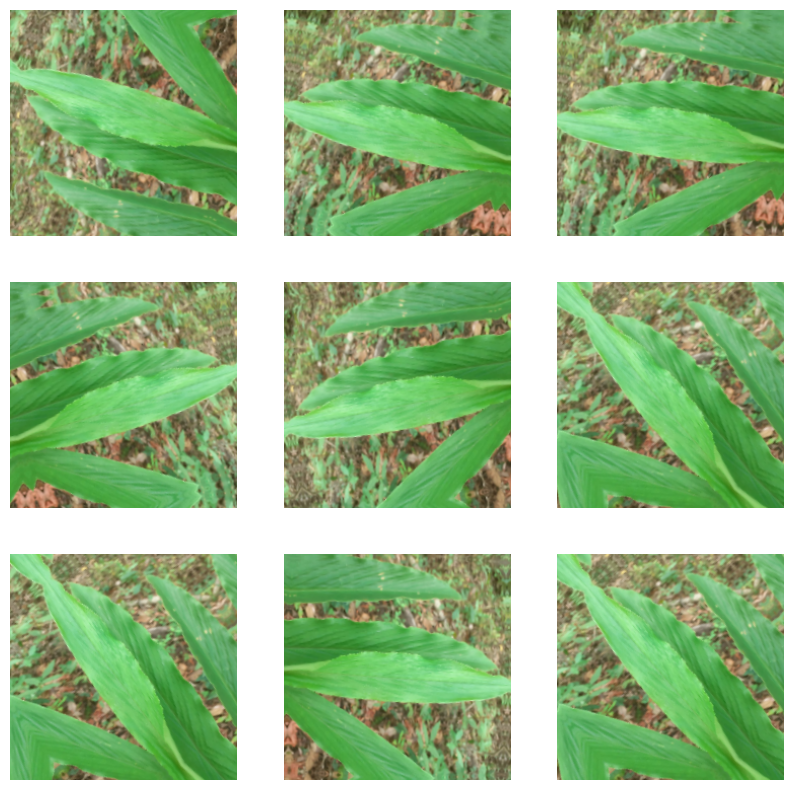

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Define the EarlyStopping callback

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# EfficientNet Model Implementation

Import the base model

In [25]:
from keras._tf_keras.keras.applications.efficientnet_v2 import EfficientNetV2B0

Create a base model

In [27]:
conv_base = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
)
conv_base.trainable = False

Add Connected layers to EfficientNet Base

In [33]:
model_eff = Sequential()
resize_and_rescale
model_eff.add(conv_base)
model_eff.add(Flatten())
model_eff.add(Dense(256,activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(BatchNormalization())
model_eff.add(Dense(num_classes,activation='sigmoid'))
model_eff.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,977,683 (83.84 MB)

 Trainable params: 16,057,859 (61.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

Compile the model

In [35]:
model_eff.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Train the model

In [36]:
epochs = 5
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8343 - loss: 0.4407 - val_accuracy: 0.9782 - val_loss: 0.0781
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9865 - loss: 0.0660 - val_accuracy: 0.9891 - val_loss: 0.0364
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9892 - loss: 0.0390 - val_accuracy: 0.9927 - val_loss: 0.0252
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9764 - loss: 0.0592 - val_accuracy: 0.9891 - val_loss: 0.0270
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9849 - loss: 0.0420 - val_accuracy: 0.9927 - val_loss: 0.0208
Restoring model weights from the end of the best epoch: 5.


### Evaluate the model

In [37]:
model_eff.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 1.0000 - loss: 0.0060


[0.008163672871887684, 1.0]

# Visualize training results

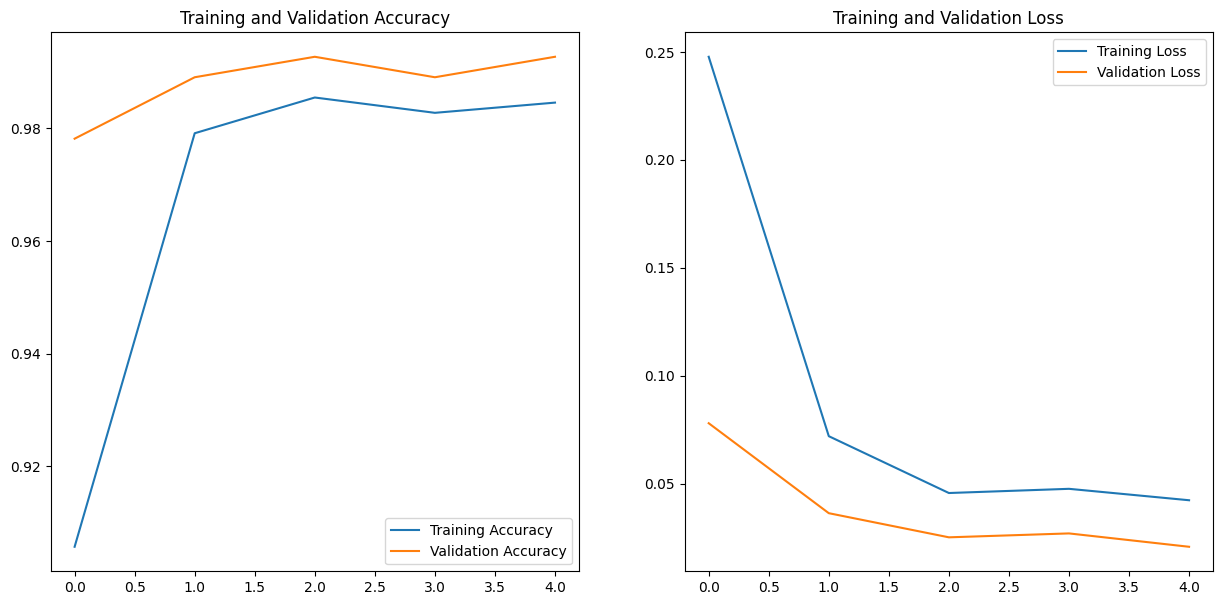

<Figure size 640x480 with 0 Axes>

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("Accuracy.png")

## Save the model

In [39]:
model_eff.save("Model EfficientNet.keras")

# DenseNet Model Implementation

In [18]:
from keras._tf_keras.keras.applications import DenseNet121, InceptionV3
base_dense = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_dense.trainable = False

In [19]:
model_dense = Sequential()
resize_and_rescale
model_dense.add(base_dense)
model_dense.add(Flatten())
model_dense.add(Dense(256,activation='relu'))
model_dense.add(Dropout(0.5))
model_dense.add(BatchNormalization())
model_dense.add(Dense(num_classes,activation='sigmoid'))
model_dense.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,884,611 (75.85 MB)

 Trainable params: 12,846,595 (49.01 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [20]:
model_dense.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [21]:
epochs = 5
history = model_dense.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.6839 - loss: 0.7572 - val_accuracy: 0.8764 - val_loss: 0.3049
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.8407 - loss: 0.3646 - val_accuracy: 0.9091 - val_loss: 0.2246
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.8795 - loss: 0.3162 - val_accuracy: 0.9018 - val_loss: 0.2506
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.8988 - loss: 0.2493 - val_accuracy: 0.9345 - val_loss: 0.2054
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.8909 - loss: 0.2788 - val_accuracy: 0.9491 - val_loss: 0.1810
Restoring model weights from the end of the best epoch: 5.


Evaluate the model

In [22]:
model_dense.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9777 - loss: 0.1574


[0.1610996425151825, 0.9710144996643066]

Visualize training accuracy and loss

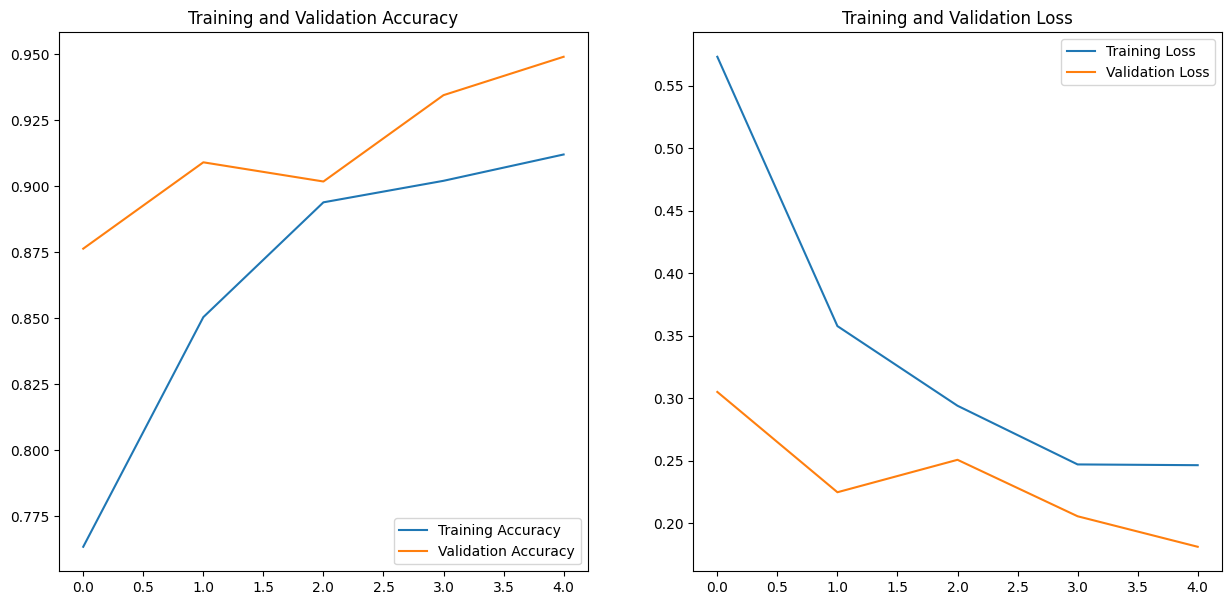

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Save the model

In [24]:
model_dense.save('Model DenseNet.keras')

# InceptionV3 Model Implementation

In [25]:
base_inc = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_inc.trainable = False

In [26]:
model_inc = Sequential()
resize_and_rescale
model_inc.add(base_inc)
model_inc.add(Flatten())
model_inc.add(Dense(256,activation='relu'))
model_inc.add(Dropout(0.5))
model_inc.add(BatchNormalization())
model_inc.add(Dense(num_classes,activation='sigmoid'))
model_inc.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,912,035 (133.18 MB)

 Trainable params: 13,108,739 (50.01 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

In [27]:
model_inc.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [28]:
epochs = 10
history = model_inc.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6384 - loss: 0.8927 - val_accuracy: 0.8182 - val_loss: 0.6727
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7105 - loss: 0.6650 - val_accuracy: 0.7491 - val_loss: 0.6923
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7818 - loss: 0.5261 - val_accuracy: 0.7818 - val_loss: 0.5694
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


Evaluate the model

In [29]:
model_inc.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8300 - loss: 0.5670 


[0.7533538341522217, 0.7681159377098083]

Visualize training accuracy and losses

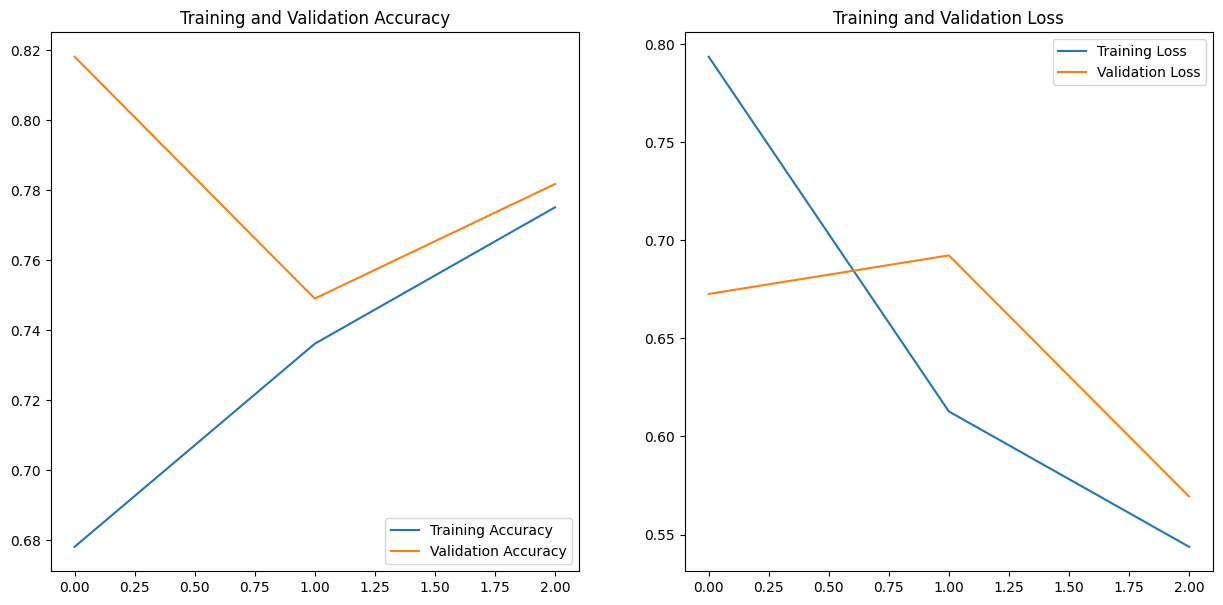

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Save the model

In [32]:
model_inc.save('Model InceptionV3.keras')